This is the template for DS3000 Final data analysis project. Once you finish, please remove all my instructions. You do not need to exactly follow the structure in the template but please make sure you have all the components. Write your report in paragraphs. Only use bullet points when list something (eg: functions) 

# Big Pal 
#### Team 2
- Audrey Ng, Lydia Lutake, Yueran Jia

In [7]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
from bs4 import BeautifulSoup
import requests

import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, r2_score, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_score


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

## Introduction


“Pokémon with Guns”, also known as Palworld, is a partially released action-adventure game featuring trainable monsters that can be equipped with firearms for combat, focusing on exploration and gathering resources. It has both single-player and multiplayer experiences, so players can choose to play alone or invite friends, but this is limited to 4 people in total. The game is noted for its action-packed dark comedy, and with a budget of $6.7 million. Nominated for the Golden Joystick Awards and The Steam Awards in 2024, and received positive feedback from players. 

To ensure players maximise their chances of succeeding in the game, we will investigate two important questions. First, we will determine whether tankier pals have weaker attacks. Our theory is that tankier pals have strong defense; they mostly like to have this to balance out their weak attack. Second, we analyze different stats and their relationship to rarity. This so we can see how valuable the category of the pals' rarity is.  


## Data 

## Webscraping and cleaning

In [8]:
def get_url_html(url):
    """
    Returns HTML from a url

    Args:
        url (str): a url

    Returns:
        html (str): HTML response from url
    """
    
    html = requests.get(url)
    return html.text

In [35]:
def clean_pal_data(html):
    """
    Scrapes pals from palworld.gg and creates a dataframe with names, HP, defense, melee attack, and shot attack statistics

    Args:
        html (str): html text object from palworld.gg

    Returns:
        clean_df (DataFrame): DataFrame with columns
                                Name (str): name of the pal
                                HP (int): health points of the pal
                                Defense (int): defense statistics of the pal
                                Melee Attack (int): melee attack statistics of the pal
                                Shot Attack (int): shot attack statistics of the pal
    """
    # create soup object with the html text object
    soup = BeautifulSoup(html, 'html.parser')

    # find all divs that have a class name of 'pal'
    all_pals = soup.find_all('div', class_='pal')

    # initialize feature lists
    pal_names = []
    pal_HP = []
    pal_defense = []
    pal_melee_attack = []
    pal_shot_attack = []
    pal_price = []
    pal_rarity = []
    pal_running_speed = []

    # iterate through each pal to get name and href
    for pal in all_pals:
        if pal.find('a'):
            href = pal.find('a')['href']    
            
        # build pal url
        pal_url = 'https://palworld.gg' + href
        
        # get html from the pal url
        pal_html = get_url_html(pal_url)

        # create soup object with the html text object from the pal url
        pal_soup = BeautifulSoup(pal_html)

        # find pal statistics by finding div with class name of 'stats'
        stats_section = pal_soup.find('div', class_='stats')
        all_stat_items = stats_section.find_all('div', class_='item')
        
        pal_names.append(href.split('/')[-1])
        
        rarity = pal_soup.find('div', class_ = 'below')
        rarity_text = rarity.find('div', class_ = 'name').text
        
        # get all stats
        stat_map = {
            'HP': pal_HP,
            'Defense': pal_defense,
            'Melee Attack': pal_melee_attack,
            'Shot Attack': pal_shot_attack,
            'Price': pal_price,
            'Running Speed': pal_running_speed,
        }

        for stat in all_stat_items:
            for key, stat_list in stat_map.items():
                if key in stat.text:
                    value = stat.find('div', class_='value').text
                    stat_list.append(value)
                    break  # stop after the first match
        pal_rarity.append(rarity_text)


    # create DataFrame
    all_pal_data = pd.DataFrame({
        'Name': pal_names,
        'HP': pal_HP,
        'Defense': pal_defense,
        'Melee Attack': pal_melee_attack,
        'Shot Attack': pal_shot_attack,
        'Price': pal_price,
        'Rarity': pal_rarity,
        'Running Speed': pal_running_speed,
    })
    return all_pal_data

In [36]:
html = get_url_html('https://palworld.gg/pals')

df = clean_pal_data(html)
df.to_csv('palworld.csv')

In [37]:
import pandas as pd
df = pd.read_csv('palworld.csv')

## Visualizations

#### visualization 1

In [38]:
def make_price_rarity_bar():
  #cast to numeric 
  df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

  # group and sort data
  group_stats = df.groupby('Rarity')['Price'].agg(['mean', 'std']).reset_index()
  rarity_order = ['Common', 'Rare', 'Epic', 'Legendary']
  group_stats['Rarity'] = pd.Categorical(group_stats['Rarity'], categories=rarity_order, ordered=True)
  group_stats = group_stats.sort_values('Rarity')

  #get stats
  x = np.arange(len(group_stats))
  means = group_stats['mean']
  stds = group_stats['std']

  plt.figure(figsize=(8, 6))
  plt.bar(x, means, yerr=stds, capsize=5, alpha=0.7, color='skyblue')

  plt.xticks(x, group_stats['Rarity'])
  plt.title('Average Price by Rarity (with Variance)')
  plt.xlabel('Rarity')
  plt.ylabel('Average Price')

  plt.show()

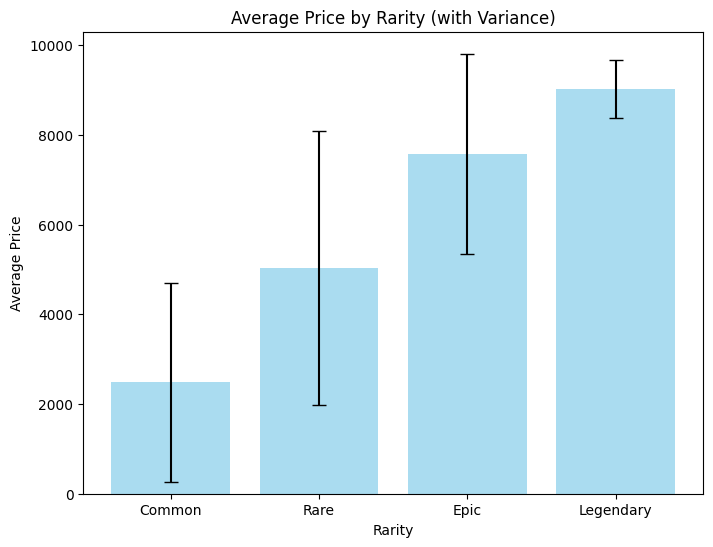

In [13]:
make_price_rarity_bar()

In this visualization, we visualize the relationship between price and rarity of pals. We used a barchart with a black line showing the standard deviation. We made this to understand the data we will use to fit our KNN model to predict for rarity, and here it is shown that average price increases between stratas of rarity

#### visualization 2

In [14]:
def make_hp_defense_bar():
  #cast to numeric and do variable creation
  df['HP'] = pd.to_numeric(df['HP'], errors='coerce')
  df['Defense'] = pd.to_numeric(df['Defense'], errors='coerce')
  df['HP_Defense'] = df['HP'] * df['Defense']

  #group and sort data
  group_stats = df.groupby('Rarity')['HP_Defense'].agg(['mean', 'std']).reset_index()
  rarity_order = ['Common', 'Rare', 'Epic', 'Legendary']
  group_stats['Rarity'] = pd.Categorical(group_stats['Rarity'], categories=rarity_order, ordered=True)
  group_stats = group_stats.sort_values('Rarity')

  # get data
  x = np.arange(len(group_stats))
  means = group_stats['mean']
  stds = group_stats['std']

  #make bar chart
  plt.figure(figsize=(8, 6))
  plt.bar(x, means, yerr=stds, capsize=5, alpha=0.7, color='skyblue')

  plt.xticks(x, group_stats['Rarity'])
  plt.title('Average HP × Defense by Rarity (with Variance)')
  plt.xlabel('Rarity')
  plt.ylabel('Average HP × Defense')

  plt.show()

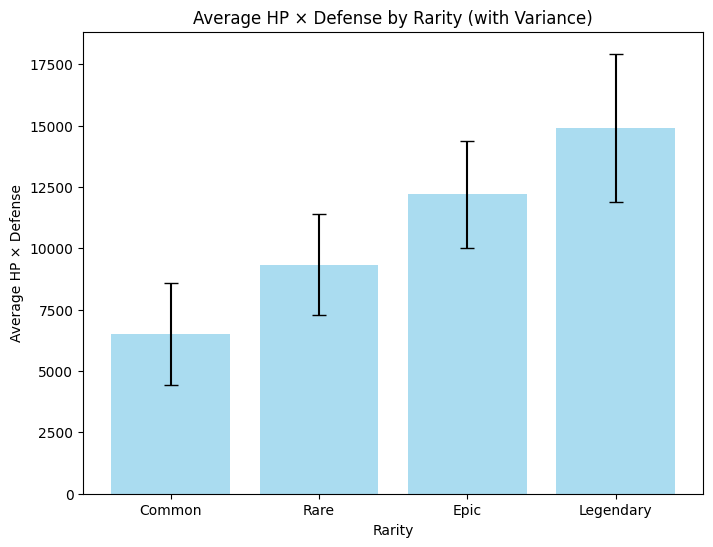

In [15]:
make_hp_defense_bar()

#### visualization 3

In [32]:
df['Melee Attack'] = pd.to_numeric(df['Melee Attack'], errors='coerce')
df['Shot Attack'] = pd.to_numeric(df['Shot Attack'], errors='coerce')

df['Average Attack'] = (df['Melee Attack'] + df['Shot Attack'])/2

group_stats = df.groupby('Rarity')['Average Attack'].agg(['mean', 'std']).reset_index()
rarity_order = ['Common', 'Rare', 'Epic', 'Legendary']
group_stats['Rarity'] = pd.Categorical(group_stats['Rarity'], categories=rarity_order, ordered=True)
group_stats = group_stats.sort_values('Rarity')

X = group_stats['Rarity']
y = group_stats['mean']
stds = group_stats['std']

In [33]:
def make_bar():
  plt.bar(X, y, yerr=stds, label='Data Points', alpha=0.7, color='skyblue', )
  plt.xlabel('Rarity')
  plt.ylabel('Attack')
  plt.title('Attack vs Rarity')
  plt.legend()
  plt.show()

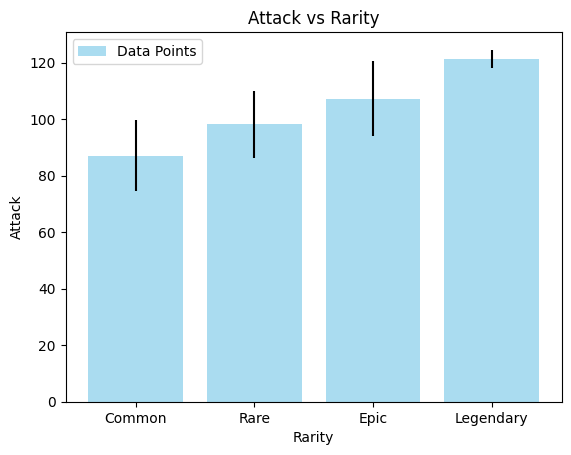

In [34]:
make_bar()

There is a moderate positive linear correlation depicting the relationship between average HP + defense and average attack, indicating that pals with a higher HP + defense have also have a higher attack on average.

## Models


#### Model 1

In [ ]:
def knn_accuracy_plot(df, x_feature_list, k_range=range(1, 21)):

    X = df[x_feature_list].values
    y = df['Rarity'].values

    #scale data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # cross validation
    n_splits = 10
    skfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    mean_scores = []

    # Try each
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_scaled, y, cv=skfold, scoring='accuracy')
        mean_scores.append(scores.mean())
        print(f"k={k}: mean accuracy={scores.mean():.4f}")

    # Plot curve
    plt.figure(figsize=(8, 5))
    plt.plot(list(k_range), mean_scores, marker='o')
    plt.xlabel("Number of Neighbors (k)")
    plt.ylabel("Mean CV Accuracy")
    plt.title("KNN Accuracy Plot")
    plt.xticks(list(k_range))
    plt.grid(True)
    plt.show()

# Example usage
# knn_elbow_plot(df, x_feature_list)


In [ ]:
def fit_knn(df, x_feature_list, k):
  x = df[x_feature_list].values
  y = df['Rarity'].values 

  #scale features
  scaler = StandardScaler()
  x_scaled = scaler.fit_transform(x) 

  #set up cross-validation
  n_splits = 10
  skfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

  knn = KNeighborsClassifier(n_neighbors=k)
  y_pred = np.empty_like(y, dtype=object)

  # cross validate
  for train_idx, test_idx in skfold.split(x_scaled, y):
      x_train, x_test = x_scaled[train_idx], x_scaled[test_idx]
      y_train = y[train_idx]

      knn.fit(x_train, y_train)
      y_pred[test_idx] = knn.predict(x_test)


  print("Classification Report:")
  print(classification_report(y, y_pred))

  # graph confuson matrix
  cm = confusion_matrix(y, y_pred, labels=np.unique(y))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
  disp.plot(cmap="Blues", xticks_rotation=45)
  plt.title("KNN Confusion Matrix")
  plt.tight_layout()
  plt.show()

/opt/anaconda3/envs/ds/lib/python3.12/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
/opt/anaconda3/envs/ds/lib/python3.12/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
/opt/anaconda3/envs/ds/lib/python3.12/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
/opt/anaconda3/envs/ds/lib/python3.12/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
/opt/anaconda3/envs/ds/lib/python3.12/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=1

k=1: mean accuracy=0.7036
k=2: mean accuracy=0.6860
k=3: mean accuracy=0.6640
k=4: mean accuracy=0.6777
k=5: mean accuracy=0.6868
k=6: mean accuracy=0.7091
k=7: mean accuracy=0.7180
k=8: mean accuracy=0.7484
k=9: mean accuracy=0.7308
k=10: mean accuracy=0.7397
k=11: mean accuracy=0.7178
k=12: mean accuracy=0.7182
k=13: mean accuracy=0.7132
k=14: mean accuracy=0.7091
k=15: mean accuracy=0.7132
k=16: mean accuracy=0.7091
k=17: mean accuracy=0.7091
k=18: mean accuracy=0.7223
k=19: mean accuracy=0.7043
k=20: mean accuracy=0.7000


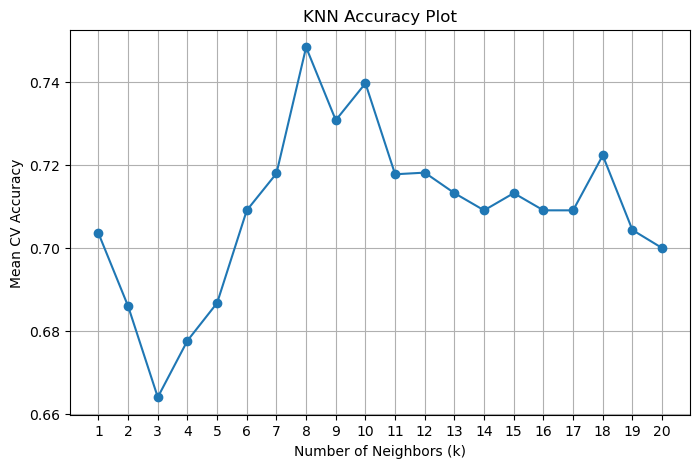

In [ ]:
x_feature_list = ['HP', 'Defense', 'Melee Attack', 'Shot Attack', 'Price']

knn_accuracy_plot(df, x_feature_list)

Classification Report:
              precision    recall  f1-score   support

      Common       0.86      0.82      0.84       101
        Epic       0.67      0.73      0.70        44
   Legendary       1.00      0.88      0.93         8
        Rare       0.64      0.64      0.64        73

    accuracy                           0.75       226
   macro avg       0.79      0.77      0.78       226
weighted avg       0.75      0.75      0.75       226



/opt/anaconda3/envs/ds/lib/python3.12/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


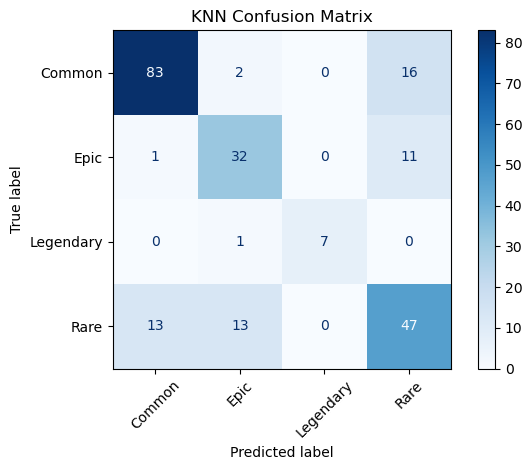

In [ ]:
fit_knn(df, x_feature_list, 8)

#### Model 2

In [41]:
X = pd.DataFrame(pd.to_numeric(df['HP'], errors='coerce') + pd.to_numeric(df['Defense'], errors='coerce')) / 2

df['Melee Attack'] = pd.to_numeric(df['Melee Attack'], errors='coerce')
df['Shot Attack'] = pd.to_numeric(df['Shot Attack'], errors='coerce')

df['Average Attack'] = (df['Melee Attack'] + df['Shot Attack']) / 2

y = df['Average Attack']

In [ ]:
def fit_lin_reg(X, y):
  # create and fit data
  model = LinearRegression()
  model.fit(X, y)

  # predict attack
  y_pred = model.predict(X)

  #get stats
  slope = model.coef_[0]
  intercept = model.intercept_

  # print out the slope and intercept values
  print(f"Slope: {slope}")
  print(f"Intercept: {intercept}")

  # get r2 and mse
  r2 = r2_score(y, y_pred)
  mse = mean_squared_error(y, y_pred)

  print(f"R2: {r2}")
  print(f"MSE: {mse}")

  # plot data and regression line
  plt.figure(figsize=(8, 6))
  plt.scatter(X, y, label='Actual Data', alpha=0.7)
  plt.plot(X, y_pred, color='red', label='Regression Line')
  plt.xlabel('Average HP and Defense')
  plt.ylabel('Average Attack')
  plt.title('Attack vs Defense')
  plt.legend()
  plt.show()

Slope: 0.5383590142084992
Intercept: 45.80171175779159
R2: 0.37320635087567744
MSE: 145.33266926053452


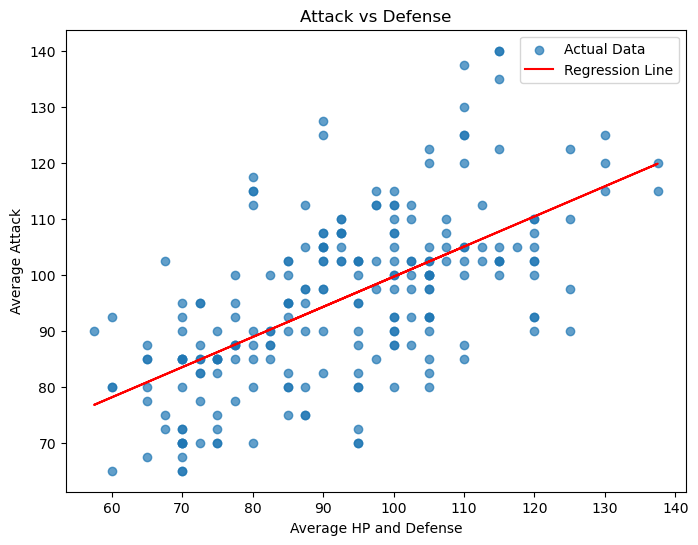

In [ ]:
fit_lin_reg(X, y)

In [42]:
y = df['Running Speed']

def fit_lin_reg_speed(X, y):
  # create and fit data
  model = LinearRegression()
  model.fit(X, y)

  # predict attack
  y_pred = model.predict(X)

  #get stats
  slope = model.coef_[0]
  intercept = model.intercept_

  # print out the slope and intercept values
  print(f"Slope: {slope}")
  print(f"Intercept: {intercept}")

  # get r2 and mse
  r2 = r2_score(y, y_pred)
  mse = mean_squared_error(y, y_pred)

  print(f"R2: {r2}")
  print(f"MSE: {mse}")

  # plot data and regression line
  plt.figure(figsize=(8, 6))
  plt.scatter(X, y, label='Actual Data', alpha=0.7)
  plt.plot(X, y_pred, color='red', label='Regression Line')
  plt.xlabel('Average HP and Defense')
  plt.ylabel('Running Speed')
  plt.title('Speed vs Defense')
  plt.legend()
  plt.show()

Slope: 7.095003664012508
Intercept: -85.26903442204468
R2: 0.26848401990824533
MSE: 40950.04035293817


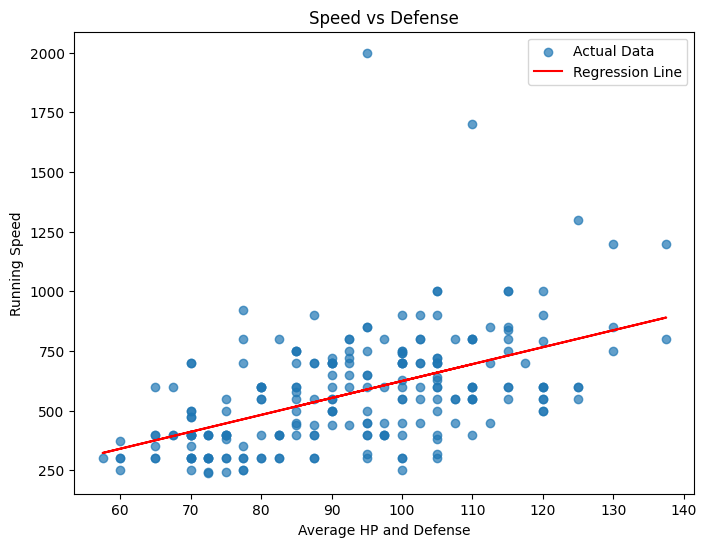

In [43]:
fit_lin_reg_speed(X, y)

- fit_knn fits a K-Nearest Neighbors classifier using the provided features and evaluates with stratified K-fold cross-validation and also prints a classification report and plots a confusion matrix. For the pre-processing, we converted all relevant features to numeric values, handled missing values by converting non-numeric entries to NaN, and standardized the features using Z-score scaling to make sure all features contribute equally to the distance metric. We made an error plot of different K number to find a highest accuracy at K = 8, so we used that. We think that using KNN is suitible because rarity is a categorical variable and KNN can capture complex and nonlinear boundaries between classes without assuming a specific distribution and we used accuracy, sensitivity (recall), specificity, and the confusion matrix for the metrics.
- fit_lin_reg fits a linear regression model, prints the slope and intercept, computes R2 and MSE on the training data, and plots the regression line. For the pre-processing, we converted HP, Defense, Melee Attack, and Shot Attack to numeric, created the predictor as the sum of HP and Defense, and created the target as the average of Melee and Shot Attack and made sure no missing values remained before fitting. We think that using linear regression is suitable because we wanted to directly test for a linear relationship between defensive capability and offensive capability in pals and we used R2 and MSE to evaluate the linear regression model because R2 measures how much variance in attack is explained by defense, while MSE quantifies the average prediction error.

## Discussion

For the K Nearest Neighbor Classification model, we find that the model is able to classify with an accuracy of 0.75. It does very well predicting for common, achieving a f1 score of 0.84. It struggles more with epic and rare, only achieving 0.7 and 0.64 data points there. For legendary, we only have 8 data points to predict, which make it hard to assess our level of success. We find that it can be possible to predict rarity using Pal stats. However, in the future, it will be important to get more data, since it is hard to assess for legendary, and may also improve the overall predictions.

For the linear regression model, we learned that there is a moderately strong correlation between the average of HP and defense and the sum of the attack powers of a pal. We find that for every increase in the average of HP and Defense, we find an increase of 0.54 in the average of the attacking stats. Answering our question that increased defensive capability does not necessarily correlate with decreased offensive capability.

Audrey did most of the work with modeling and graphing the linear regression.
Yueran fitted the K-nearest neighbhor and wrote the webscraping code.
Lydia handled the writing and presentation segments.